## COVID-19: Paraíba 2020-2022

### Integrantes:

* [João Henrique de Araújo Pereira](https://github.com/joaoh224488)&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;&nbsp;Matrícula: 20210026705 
* [Maria Raquel Souza Martinez](https://github.com/maria-raquel)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp; Matrícula: 20200025900
* [Maxwel de Andrade Barbosa](https://github.com/maxbarbosa)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp; Matrícula: 20210067083



<p align="center"><img src="https://www.camara.leg.br/midias/image/2020/10/img20201022140139807-768x512.jpg" width="70%" height="70%"/></p>

Fonte: https://www.camara.leg.br/midias/image/2020/10/img20201022140139807-768x512.jpg

## Introdução e objetivos

### Objetivo geral:



### Objetivos específicos:

### Bibliotecas utilizadas:

As bibliotecas usadas no projeto estão contidas no arquivo `requirements.txt` presente no diretório raiz [deste trabalho](https://github.com/maxbarbosa/data-science-final-project).

Elas podem ser instaladas através da execução da instrução abaixo dentro do programa de linha de comando do seu sistema operacional:

    pip install -r requirements.txt


### Importação das bibliotecas e carregamento dos dados:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import fix_vaxs
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

vax_df      =  pd.read_csv("datasets/dados_vacinacao.csv")
casos_br_df =  pd.read_csv("datasets/dados_br.csv")
casos_pb_df =  pd.read_csv("datasets/dados_pb.csv")

### Dados - Principais váriaveis utilizadas:

[Open Data SUS](https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao) (dados_vacinacao.csv):

* paciente_idade (idade do vacinado)
* paciente_endereco_nmMunicipio (nome do município de endereço do vacinado)
* paciente_racaCor_valor (descrição da raça/cor do vacinado)
* vacina_descricao_dose (descrição da dose. Exemplo: "2ª dose")
* vacina_nome (nome da vacina/produto)

[Brasil IO](https://brasil.io/covid19/PB/) - BR, PB (dados_br e dados_pb.csv):

* city (município brasileiro o qual detém tais dados)
* confirmed (quantidade de casos confirmados)
* confirmed_per_100k_inhabitants (casos confirmados a cada 100 mil habitantes)
* deaths (número de mortes)
* death_rate (taxa de mortalidade)
* demographic_density (densidade demográfica das cidades paraibanas conforme o censo 2010 - IBGE)




## Pré-processamento

O dataset disponibilizado pela plataforma Open Data SUS possui algumas células com mais de um valor. Tais células ocasionam um erro de leitura para o Python. Só é possível corrigir tal erro através de um processo pseudo-manual, processo este que foi resolvido por nossa equipe e que o passo a passo está detalhado [nesse arquivo](https://github.com/maxbarbosa/data-science-final-project/tree/main/datasets#readme) do repositório.

O dataset original possui 2.806.755 linhas e 32 colunas, das quais 15 foram removidas por apresentar dados repetidos e/ou nada relevantes para este trabalho. Restando 17 colunas a serem utilizadas.

O código abaixo explicita o processo de remoção das 15 colunas do dataset original:


```python
import pandas as pd
df = pd.read_csv('dados_vacinacao.csv')

df = df.drop(
        ['document_id',  
        'paciente_endereco_coIbgeMunicipio', 
        'paciente_endereco_coPais',
        'paciente_endereco_nmPais',
        'paciente_endereco_uf', 
        'paciente_nacionalidade_enumNacionalidade', 
        'estabelecimento_valor',
        'estabelecimento_razaoSocial', 
        'estalecimento_noFantasia',
        'estabelecimento_municipio_codigo', 
        'estabelecimento_uf', 
        'vacina_fabricante_nome',
        'vacina_fabricante_referencia', 
        'sistema_origem'], 
	axis= 1
)

df = df.iloc[: , [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 0]]

df.to_csv("dados_vacinacao.csv", index = False)
```


Após a realização da etapa descrita acima, algumas colunas do novo dataset gerado foram criadas com o tipo _float_, sendo inicialmente _int_ seu tipo de dado, para realizar a correção em tais colunas, o seguinte trecho de código foi executado:

```python
df.paciente_idade = df.paciente_idade.fillna(0)
df.paciente_racaCor_codigo = df.paciente_racaCor_codigo.fillna(0)
df.vacina_grupoAtendimento_codigo = df.vacina_grupoAtendimento_codigo.fillna(0)
df.vacina_categoria_codigo = df.vacina_categoria_codigo.fillna(0)
df.vacina_codigo = df.vacina_codigo.fillna(0)

df = df.astype({
    "paciente_idade":int,
    "paciente_racaCor_codigo":int,
    "vacina_grupoAtendimento_codigo":int,
    "vacina_categoria_codigo": int,
    "vacina_codigo": int
    })

df.to_csv("dados_vacinacao.csv", index = False)
```

## Limpeza dos dados

Durante o decorrer da exploração inicial do dataset, foi constatado que valores negativos e valores acima de 110 anos estavam presentes na coluna que armazena a idade dos pacientes. Como a quantidade desses valores anômalos é baixa (185 casos), convém deletá-los. Além disso, na coluna que armazena a data na qual o paciente foi vacinado, há alguns pacientes que foram vacinados antes da primeira dose de vacina ser aplicada no Brasil no dia 17 de janeiro de 2021. <br>
A remoção desses dados não afetará relevantemente este estudo, pois esse número é insignificante se comparado a quase 3 milhões de entradas totais do dataset.


In [2]:
vax_df.vacina_dataAplicacao = pd.to_datetime(vax_df.vacina_dataAplicacao)

In [3]:
drop_this = vax_df.loc[(vax_df.paciente_idade > 110) | (vax_df.paciente_idade < 5) | (vax_df.vacina_dataAplicacao < pd.Timestamp(2021, 1, 17))]

drop_this

,paciente_idade,paciente_dataNascimento,paciente_enumSexoBiologico,paciente_racaCor_codigo,paciente_racaCor_valor,paciente_endereco_nmMunicipio,paciente_endereco_cep,estabelecimento_municipio_nome,vacina_grupoAtendimento_codigo,vacina_grupoAtendimento_nome,vacina_categoria_codigo,vacina_categoria_nome,vacina_dataAplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,paciente_id
15030,121,1899-12-30,F,99,SEM INFORMACAO,PICUI,NaN,PICUI,917,Profissionais e Auxiliares de limpeza,9,Trabalhadores de Saúde,2021-01-28,1ª Dose,85,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,f1c3b1a19f65bc23f26fd66ad23411e8ce0583295b8471...
38305,2,2019-09-16,F,99,SEM INFORMACAO,GUARULHOS,7142,SOUSA,207,Pessoas de 5 a 11 anos,0,NaN,2022-03-28,2ª Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,2148017dbfa2015a4ed271aac5dcadeca60557c279e51c...
39339,0,1974-11-16,F,99,SEM INFORMACAO,CAMPINA GRANDE,58401,CAMPINA GRANDE,201,Pessoas de 18 a 64 anos,2,Faixa Etária,1975-02-20,1ª Dose,88,COVID-19 JANSSEN - Ad26.COV2.S,046d325facf10e1f13f78e4e9195cb2dc27953e5075484...
41754,0,1986-04-20,F,99,SEM INFORMACAO,CAMPINA GRANDE,58401,CAMPINA GRANDE,201,Pessoas de 18 a 64 anos,2,Faixa Etária,1986-04-20,Reforço,87,COVID-19 PFIZER - COMIRNATY,0469ebe1ad08f5040adca17ec248430e5fbf112b749c47...
46665,-8,1983-02-28,M,99,SEM INFORMACAO,MACEIO,None,CAMPINA GRANDE,201,Pessoas de 18 a 64 anos,2,Faixa Etária,1974-12-05,2ª Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,22618b1bff1b85fa4c238413d60891763eb37fcacf7cdf...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727528,0,1962-07-08,M,99,SEM INFORMACAO,BAYEUX,58305,JOAO PESSOA,201,Pessoas de 18 a 64 anos,2,Faixa Etária,1962-06-20,1ª Dose,87,COVID-19 PFIZER - COMIRNATY,e41bf7e6e369aa29e6d26ec77d1d8daa0f60a924a4cbcc...
2733405,111,1910-01-12,F,3,PARDA,JOAO PESSOA,58078,JOAO PESSOA,205,Pessoas de 80 anos ou mais,2,Faixa Etária,2021-02-07,1ª Dose,86,COVID-19 SINOVAC/BUTANTAN - CORONAVAC,dbe3f058be16f383a8392fbb4f89681caf441363366bfa...
2791852,0,1999-02-17,M,3,PARDA,JOAO PESSOA,58034,JOAO PESSOA,507,Policial Militar,5,Forças de Segurança e Salvamento,1999-02-17,2ª Dose,85,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,7f5626eb38d0699cd1c44aef7dfc61bc02ab1589d35433...
2798130,0,1980-04-24,M,99,SEM INFORMACAO,CAMPINA GRANDE,58107,CAMPINA GRANDE,201,Pessoas de 18 a 64 anos,2,Faixa Etária,1980-04-24,2ª Dose,85,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD,dc02c8fb8b211283163a6d8680bbb81216e0831436bf94...


In [4]:
len(drop_this)

185

In [5]:
vax_df.drop(drop_this.index, inplace = True)

### Deletando as linhas incoerentes


In [6]:
vax_df.vacina_dataAplicacao = pd.to_datetime(vax_df.vacina_dataAplicacao)

In [7]:
drop_this = vax_df.loc[(vax_df.paciente_idade > 110) | (vax_df.paciente_idade < 5) | (vax_df.vacina_dataAplicacao < pd.Timestamp(2021, 1, 17))]

drop_this

,paciente_idade,paciente_dataNascimento,paciente_enumSexoBiologico,paciente_racaCor_codigo,paciente_racaCor_valor,paciente_endereco_nmMunicipio,paciente_endereco_cep,estabelecimento_municipio_nome,vacina_grupoAtendimento_codigo,vacina_grupoAtendimento_nome,vacina_categoria_codigo,vacina_categoria_nome,vacina_dataAplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,paciente_id


In [8]:
vax_df.drop(drop_this.index, inplace = True)

Inicialmente, foi verificado a presença de duplicação para o nome do fabricante das vacinas. A exemplo de _COVID-19 SINOVAC/BUTANTAN - CORONAVAC_ e _COVID-19 SINOVAC - CORONAVAC_ que implicam o mesmo produto, porém estão tipadas com nomes diferentes.

In [9]:
vax_names = pd.DataFrame({"vacina_nome": vax_df.vacina_nome.sort_values().unique()})
vax_names

,vacina_nome
0,COVID-19 ASTRAZENECA - ChAdOx1-S
1,COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD
2,COVID-19 JANSSEN - Ad26.COV2.S
3,COVID-19 PEDIÁTRICA - PFIZER COMIRNATY
4,COVID-19 PFIZER - COMIRNATY
5,COVID-19 SINOVAC - CORONAVAC
6,COVID-19 SINOVAC/BUTANTAN - CORONAVAC


### Removendo a duplicação do nome das vacinas

In [10]:
fix_vaxs.rename_vax(vax_df)
#Unificando o código das vacinas duplicadas
fix_vaxs.update_vax_code(vax_df)

In [11]:
vax_names = pd.DataFrame({"vacina_nome": vax_df.vacina_nome.sort_values().unique()})
vax_names

,vacina_nome
0,ASTRAZENECA
1,CORONAVAC
2,JANSEN
3,PFIZER
4,PFIZER PEDIÁTRICA


Ainda na exploração inicial, foi verificado a presença de duplicação para a descrição das doses aplicadas. A exemplo de 'Dose Inicial' e '1ª Dose' que implicam o mesmo sentido, porém estão tipadas com nomes diferentes.

In [12]:
vax_dose = pd.DataFrame({"vacina_descricao_dose": vax_df.vacina_descricao_dose.sort_values().unique()})
vax_dose


,vacina_descricao_dose
0,1ª Dose
1,2ª Dose
2,2ª Dose Revacinação
3,2º Reforço
4,3ª Dose
5,4ª Dose
6,Dose
7,Dose Adicional
8,Dose Inicial
9,Reforço


### Removendo a duplicação da descrição das doses aplicadas

In [13]:
fix_vaxs.rename_doses(vax_df)

In [14]:
vax_dose = pd.DataFrame({"vacina_descricao_dose": vax_df.vacina_descricao_dose.sort_values().unique()})
vax_dose


,vacina_descricao_dose
0,1ª Dose
1,2ª Dose
2,2º Reforço
3,Dose única
4,Reforço


## Exploração inicial

O dataset `dados_vacinacao.csv` tem informações sobre doses individuais da vacina contra COVID-19 aplicada pelo SUS no estado da Paraíba.

In [15]:
vax_df.head()

,paciente_idade,paciente_dataNascimento,paciente_enumSexoBiologico,paciente_racaCor_codigo,paciente_racaCor_valor,paciente_endereco_nmMunicipio,paciente_endereco_cep,estabelecimento_municipio_nome,vacina_grupoAtendimento_codigo,vacina_grupoAtendimento_nome,vacina_categoria_codigo,vacina_categoria_nome,vacina_dataAplicacao,vacina_descricao_dose,vacina_codigo,vacina_nome,paciente_id
0,44,1977-04-18,M,1,BRANCA,ARAPIRACA,57510,PATOS,912,Médico,9,Trabalhadores de Saúde,2021-11-11,Reforço,87,PFIZER,f9495cb04daf5adb495d22c9c88b31883f191fb762ab27...
1,5,2016-11-18,M,1,BRANCA,PARELHAS,None,CAMPINA GRANDE,207,Pessoas de 5 a 11 anos,0,NaN,2022-02-07,1ª Dose,99,PFIZER PEDIÁTRICA,52288faace8c986872faca7101868ae8a23fefd435cd51...
2,39,1982-01-23,F,99,SEM INFORMACAO,CAMPINA GRANDE,58410,CAMPINA GRANDE,201,Pessoas de 18 a 64 anos,2,Faixa Etária,2021-07-16,1ª Dose,85,ASTRAZENECA,0ffaed327aac7fe8abf0b35471b0b1fa60f9fc48ff7d9c...
3,33,1988-07-20,M,2,PRETA,BAYEUX,58110,BAYEUX,201,Pessoas de 18 a 64 anos,2,Faixa Etária,2021-07-23,1ª Dose,85,ASTRAZENECA,fe78cee14dce3436024728b1d760439861021207a32712...
4,27,1994-03-22,M,3,PARDA,JOAO PESSOA,58058,JOAO PESSOA,201,Pessoas de 18 a 64 anos,2,Faixa Etária,2021-12-07,2ª Dose,87,PFIZER,470944c18359d6a1fea2a53194d29bfdb7ce1d21b47979...


Usando a função describe, calculamos rapidamente algumas medidas de centralidade e dispersão para a variável idade:

* Temos 2.806.755 entradas;
* A média de idades é 41,16 anos, com desvio padrão de 20,21 anos;
* O valor mínimo entre as idades é 0 anos;
* O valor máximo entre as idades é 115 anos;
* O primeiro quartil é 25 anos, a mediana é 39, o terceiro quartil é 56 anos.

In [16]:
vax_df["paciente_idade"].describe()

count    2.806607e+06
mean     4.116460e+01
std      2.021475e+01
min      5.000000e+00
25%      2.500000e+01
50%      3.900000e+01
75%      5.600000e+01
max      1.100000e+02
Name: paciente_idade, dtype: float64

Observamos que temos valores bem próximos de média, mediana e moda para essa variável (41.16, 39 e 39, respectivamente).

In [17]:
vax_df["paciente_idade"].mode()

0    39
dtype: int64

O dataset `dados_pb.csv` tem informações sobre o COVID-19 em todos os municípios da Paraíba, atualizado por último no dia 22/08/21. Dentre outras informações conforme o último censo realizado pelo IBGE.

In [18]:
casos_pb_df.head()

,date,city,confirmed,deaths,estimated_population,confirmed_per_100k_inhabitants,death_rate,pib_per_capita,n_vaccinations,demographic_density
0,2021-08-22,AGUA BRANCA,1128,14,10306,10945.08054,0.0124,8074.16,6754,39.94
1,2021-08-22,AGUIAR,528,5,5630,9378.33037,0.0095,8897.54,3790,16.04
2,2021-08-22,ALAGOA GRANDE,4117,72,28439,14476.59904,0.0175,9699.38,21931,88.84
3,2021-08-22,ALAGOA NOVA,1511,25,20921,7222.40811,0.0165,15631.55,14518,160.98
4,2021-08-22,ALAGOINHA,2072,25,14560,14230.76923,0.0121,7934.57,9389,139.99


### Casos confirmados por município

Armazenados na coluna `confirmed`

In [19]:
casos_pb_df['confirmed'].describe()

count       223.000000
mean       1930.986547
std        7639.848374
min          60.000000
25%         362.500000
50%         655.000000
75%        1295.000000
max      103940.000000
Name: confirmed, dtype: float64

Usando a função describe, calculamos rapidamente algumas medidas de centralidade e dispersão para a quantidade de casos de cada município.

Vemos que a média de casos por município é 1930,98, porém o desvio padrão é 7639,84.

Podemos também observar que a diferença entre o valor mínimo, o primeiro quartil e o segundo quartil são próximas, em torno de 300 casos. A diferença entre o segundo quartil e o terceiro quartil é o dobro disso, quase 600. Já a diferença entre o terceiro quartil e o valor máximo é mais de 10.000 casos. Com isso, podemos especular que o valor máximo representa um outlier, ou que poucos municípios (menos de 25%) concentram a maior quantidade de casos de COVID-19 no estado.

In [20]:
casos_pb_df.confirmed.describe()

count       223.000000
mean       1930.986547
std        7639.848374
min          60.000000
25%         362.500000
50%         655.000000
75%        1295.000000
max      103940.000000
Name: confirmed, dtype: float64

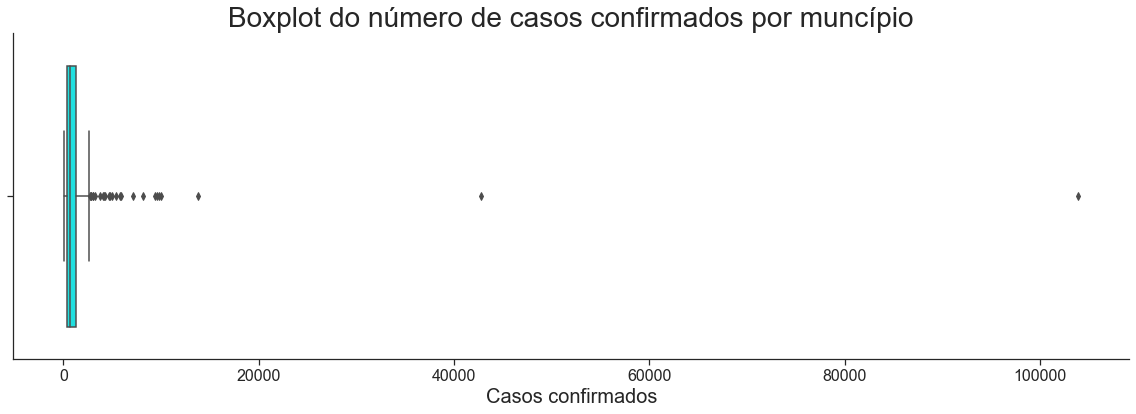

In [21]:
ax = sns.boxplot(data = casos_pb_df , x = 'confirmed', color='cyan')
ax.set_title('Boxplot do número de casos confirmados por muncípio', fontsize=28)
ax.figure.set_size_inches(20,6)
ax.set_xlabel('Casos confirmados', fontsize=20)
ax.tick_params(labelsize=16)


In [22]:
casos_pb_df[casos_pb_df['confirmed'] > 40000]

,date,city,confirmed,deaths,estimated_population,confirmed_per_100k_inhabitants,death_rate,pib_per_capita,n_vaccinations,demographic_density
49,2021-08-22,CAMPINA GRANDE,42778,1084,411807,10387.87587,0.0253,23210.44,266264,648.31
93,2021-08-22,JOAO PESSOA,103940,2890,817511,12714.20201,0.0278,25768.09,593097,3421.28


O boxplot que representa a distribuição dos casos por município é extremamente achatado, de tal forma que se torna ilegível. Isso ocorre pois os dois maiores municípios do Estado, João Pessoa e Campina Grande, concentram muitos mais casos que os demais municípios. Além disso, mesmo não os levando em conta, ainda temos muitos casos outliers além deles. Isso nos mostra que os casos de covid no Estado da Paraíba não estão distribuídos uniformemente entre os municípios, e sim concentrados em focos. 

### Mortes por COVID-19 confirmadas por município

Armazenados na coluna `deaths`

In [23]:
casos_pb_df.deaths.describe()

count     223.000000
mean       40.973094
std       208.290704
min         0.000000
25%         6.000000
50%        11.000000
75%        25.000000
max      2890.000000
Name: deaths, dtype: float64

Similarmente à quantidade de casos, a média de mortes por municípios tem média baixa, 40,97, porém desvio padrão alto, 208,29. 

Observamos que os valores mínino, e de primeiro, segundo e terceiro quartil são próximos (0, 6, 11 e 25 respectivamente), porém o valor máximo apresenta um salto enorme (2890). Vimos que poucos municípios concentram mais casos e consequentemente devem concentrar mais mortes, mas talvez outro fator para esse fenômeno possa ser o fato que municípios menores têm menos estrutura hospitalar para lidar com casos mais graves da doença, e é comum vermos esses pacientes serem transportados para municípios maiores para melhor tratamento. Dessa forma, caso o paciente venha a óbito, talvez ele seja registrado na capital, por exemplo, ao invés do seu município de origem, inflando mais esses números.

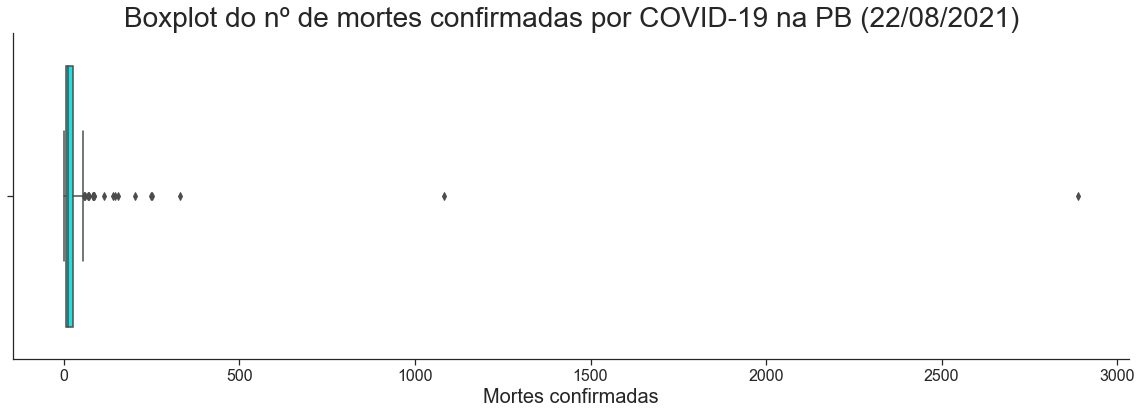

In [24]:
ax = sns.boxplot(data = casos_pb_df , x = 'deaths', color = 'cyan')
ax.set_title('Boxplot do nº de mortes confirmadas por COVID-19 na PB (22/08/2021)', fontsize = 28)
ax.figure.set_size_inches(20, 6)
ax.set_xlabel('Mortes confirmadas', fontsize = 20)
ax.tick_params(labelsize = 16)

In [25]:
casos_pb_df[casos_pb_df['deaths'] > 1000]

,date,city,confirmed,deaths,estimated_population,confirmed_per_100k_inhabitants,death_rate,pib_per_capita,n_vaccinations,demographic_density
49,2021-08-22,CAMPINA GRANDE,42778,1084,411807,10387.87587,0.0253,23210.44,266264,648.31
93,2021-08-22,JOAO PESSOA,103940,2890,817511,12714.20201,0.0278,25768.09,593097,3421.28


Novamente vemos um gráfico boxplot achatado, mostrando que, tal qual os casos de COVID-19, as mortes da doença também se concentram em poucos municípios outliers.

### População estimada

Armazenados na coluna `estimated_population`

In [26]:
casos_pb_df.estimated_population.describe()

count       223.000000
mean      18113.349776
std       62236.235680
min        1758.000000
25%        4551.500000
50%        7286.000000
75%       15363.000000
max      817511.000000
Name: estimated_population, dtype: float64

Observando as medidas de centralidade dos dados de população dos municípios paraibanos, vemos novamente o comportamento apresentado nas variáveis anteriores: média baixa, desvio padrão alto, valores de primeiro, segundo e terceiro quartil próximos com um salto muito grande entre o último e o valor máximo. Isso nos mostra que grande parte da população do estado encontra-se concentrada em poucos municípios.

Isso nos mostra que ocorre uma grande concentração de casos e mortes em poucos municípios pois existe essa concentração populacional.

Podemos observar isso melhor no gráfico boxplot da variável.

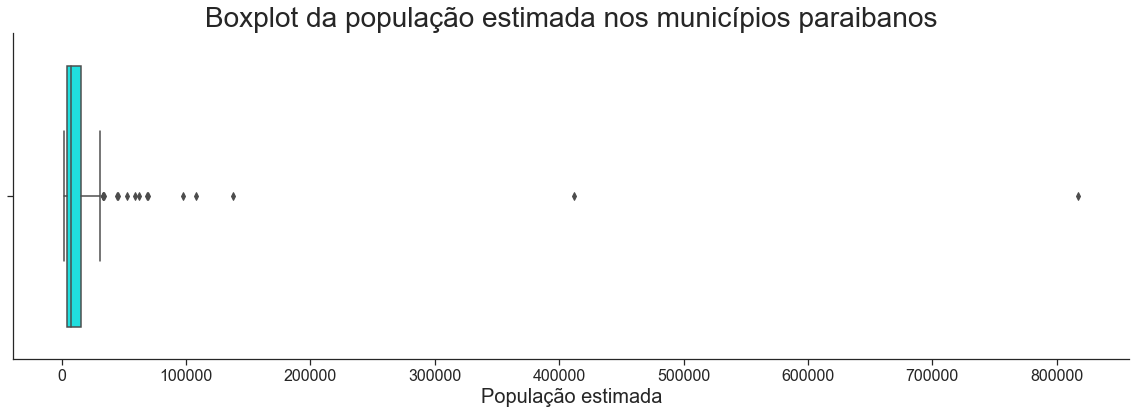

In [27]:
ax = sns.boxplot(data = casos_pb_df , x = 'estimated_population', color = 'cyan')
ax.set_title('Boxplot da população estimada nos municípios paraibanos', fontsize = 28)
ax.figure.set_size_inches(20, 6)
ax.set_xlabel('População estimada', fontsize = 20)
ax.tick_params(labelsize = 16)

### Casos confirmados a cada 100 mil habitantes por município

Armazenados na coluna `confirmed_per_100k_inhabitants`

In [28]:
casos_pb_df.confirmed_per_100k_inhabitants.describe()

count      223.000000
mean      9242.325208
std       3524.619628
min       1623.815970
25%       6626.868160
50%       8836.278760
75%      11430.389445
max      18192.675160
Name: confirmed_per_100k_inhabitants, dtype: float64

Quando calculamos as medidas de centralidade da quantidade de casos relativas à população de cada município, podemos fazer análises mais pontuais, que não são distorcidas pela diferença populacional. Vemos que esses dados são bem menos dispersos que os dados em quantidades absolutas.

A média de mortes a cada 100 mil habitantes é 9242.32, o desvio padrão é 3524.61, os quartis são 6626.86, 8836.27 e 11430.38. Os valores mínimo e máximo são 1623.81 e 18192.67. 

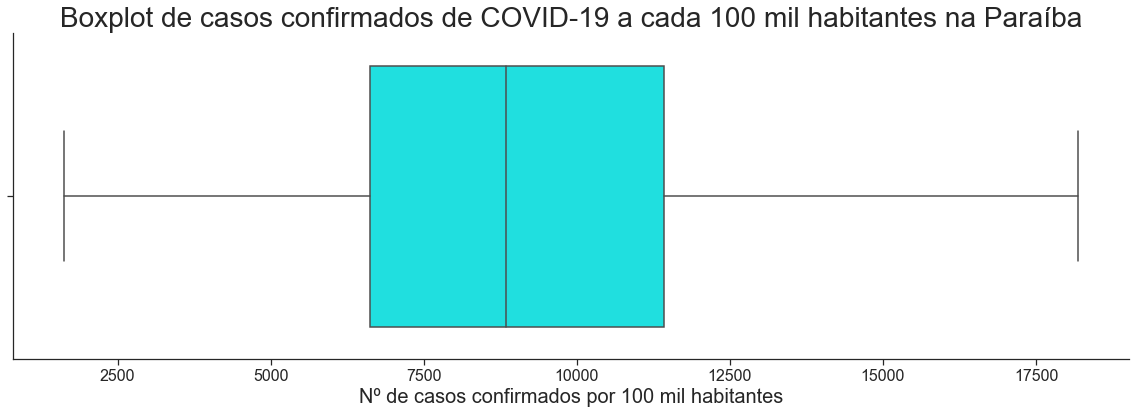

In [29]:
ax = sns.boxplot(data = casos_pb_df , x = 'confirmed_per_100k_inhabitants', color = 'cyan')
ax.set_title('Boxplot de casos confirmados de COVID-19 a cada 100 mil habitantes na Paraíba', fontsize = 28)
ax.figure.set_size_inches(20, 6)
ax.set_xlabel('Nº de casos confirmados por 100 mil habitantes', fontsize = 20)
ax.tick_params(labelsize = 16)

O boxplot dessa váriavel é muito mais legível do que o das variáveis anteriores.

### Mortalidade da COVID-19 por município

Razão entre a quantidade absoluta de mortes e a quantidade absoluta de casos. Armazenados na coluna  `death_rate`

In [30]:
casos_pb_df.death_rate.describe()

count    223.000000
mean       0.018596
std        0.009877
min        0.000000
25%        0.012100
50%        0.017200
75%        0.022750
max        0.066700
Name: death_rate, dtype: float64

A mortalidade média é de 0.018, o desvio padrão é 0.0098. Os quartis são 0.012, 0.017 e 0.022. O valor máximo é 0.066. 

Vemos um salto muito grande do terceiro quartil para o valor máximo. Os valores quartis ficam todos próximos à média, porém o valor máximo é 3.6 vezes maior que ela. 

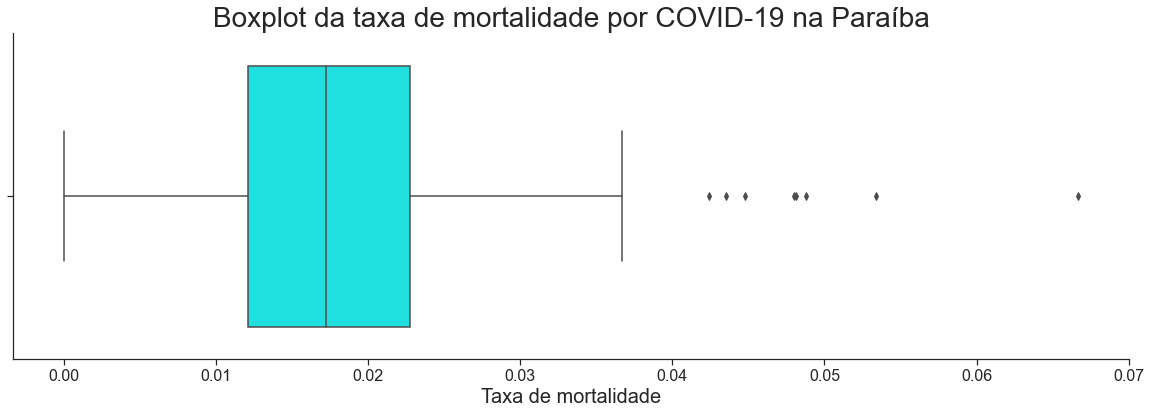

In [31]:
ax = sns.boxplot(data = casos_pb_df , x = 'death_rate', color = 'cyan')
ax.set_title('Boxplot da taxa de mortalidade por COVID-19 na Paraíba', fontsize = 28)
ax.figure.set_size_inches(20, 6)
ax.set_xlabel('Taxa de mortalidade', fontsize = 20)
ax.tick_params(labelsize = 16)

In [32]:
casos_pb_df[casos_pb_df.death_rate > 0.04]['death_rate'].count()

8

Observando o boxplot da mortalidade, vemos que há 8 municípios onde a COVID-19 foi anormalmente mais mortal do que no resto da Paraíba.

## Comparação com o cenário brasileiro

Agora, iremos analisar como esses dados da COVID-19 na Paraíba se comparam com o resto do Brasil.

Utilizaremos o mesmo modelo de dataset, desta vez que inclui todos os municípios do país

In [33]:
casos_br_df.head()

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
0,2022-03-26,PI,Acauã,city,228,2,True,7102.0,2200053.0,3210.36328,0.0088
1,2022-03-26,PI,Agricolândia,city,829,10,True,5131.0,2200103.0,16156.69460,0.0121
2,2022-03-26,PI,Água Branca,city,1702,77,True,17470.0,2200202.0,9742.41557,0.0452
3,2022-03-26,PI,Alagoinha do Piauí,city,402,13,True,7665.0,2200251.0,5244.61840,0.0323
4,2022-03-26,PI,Alegrete do Piauí,city,553,9,True,4918.0,2200277.0,11244.40830,0.0163


In [34]:
casos_br_df.describe()

,confirmed,deaths,estimated_population,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
count,5589.000000,5589.000000,5.570000e+03,5.570000e+03,5570.000000,5589.000000
mean,4213.793165,110.104312,3.801718e+04,3.253591e+06,11403.035463,0.022913
std,20947.540060,810.330564,2.228930e+05,9.849103e+05,6275.323937,0.014855
min,0.000000,0.000000,7.760000e+02,1.100015e+06,178.954900,0.000000
25%,518.000000,9.000000,5.442250e+03,2.512126e+06,6962.299600,0.013900
50%,1085.000000,22.000000,1.166550e+04,3.146280e+06,10347.400315,0.020300
75%,2635.000000,54.000000,2.566375e+04,4.119190e+06,14449.463822,0.028500
max,976214.000000,39352.000000,1.232523e+07,5.300108e+06,51915.708810,0.266700


Quanto à média de casos, a brasileira é 4213.79 e a paraibana é 1930.98 (Paraíba bem abaixo da média nacional).
Quanto à média de mortes, a brasileira é 110.10 e a paraibana é 40.97 (Paraíba bem abaixo da média nacional).
Quanto à média de casos a cada 100 mil habitantes, a brasileira é 11403.03 e a paraibana é 9242.32 (Paraíba um tanto abaixo da média nacional).
Quanto à mortalidade média, a brasileira é 0.0229 e a paraibana é 0.0185 (Paraíba um tanto abaixo da média nacional).

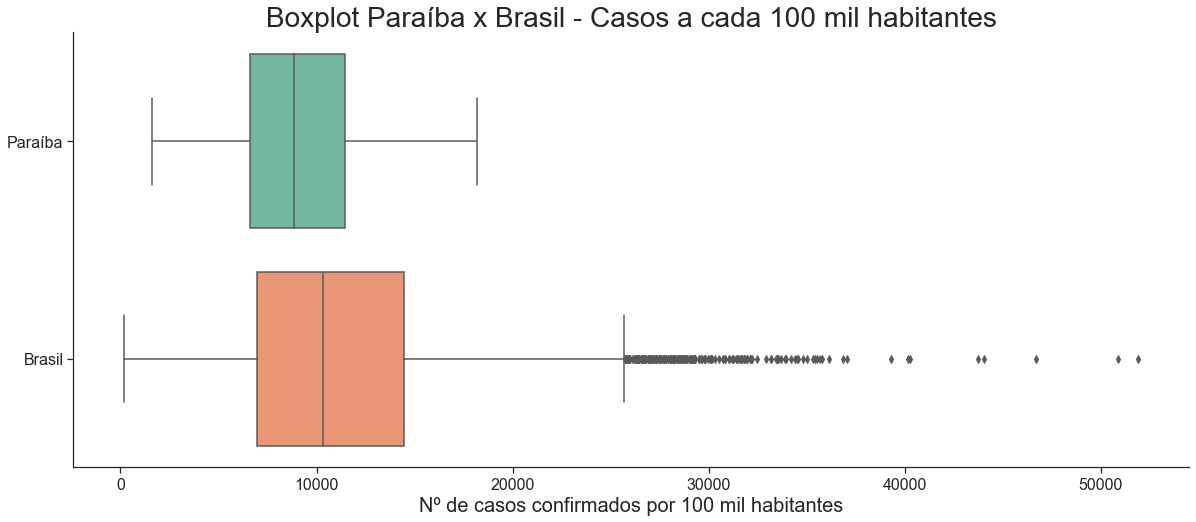

In [35]:
data_cp100k = [casos_pb_df.confirmed_per_100k_inhabitants, casos_br_df.confirmed_per_100k_inhabitants]
headers_cp100k = ['Paraíba', 'Brasil']

compare_cp100k = pd.concat(data_cp100k, axis = 1, keys = headers_cp100k)

bp_cp100k = sns.boxplot(data = compare_cp100k, orient = 'h', palette = 'Set2', order = ['Paraíba', 'Brasil'])
bp_cp100k.set_title('Boxplot Paraíba x Brasil - Casos a cada 100 mil habitantes', fontsize = 28)
bp_cp100k.set_xlabel('Nº de casos confirmados por 100 mil habitantes', fontsize = 20)
bp_cp100k.figure.set_size_inches(20, 8)
bp_cp100k.tick_params(labelsize = 16)

Vemos que, quanto aos casos a cada 100 mil habitantes, a Paraíba ficou bem, comparada ao cenário nacional. Os valores de primeiro quartil são aproximadamente iguais e os de mediana são muito próximos. O terceiro quartil do boxplot paraibano já fica um pouco mais atrás do nacional, e não há presença de outliers, ao contrário do outro.

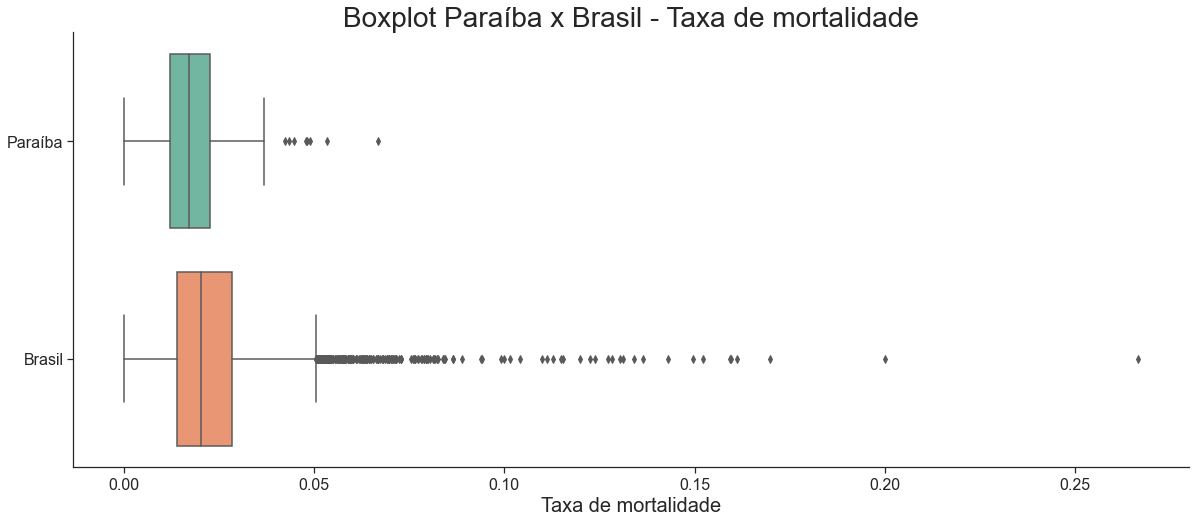

In [36]:
data_dr = [casos_pb_df.death_rate, casos_br_df.death_rate]
headers_dr = ['Paraíba', 'Brasil']

compare_dr = pd.concat(data_dr, axis = 1, keys = headers_dr)

bp_dr = sns.boxplot(data = compare_dr, orient = 'h', palette = 'Set2', order = ['Paraíba', 'Brasil'])
bp_dr.set_title('Boxplot Paraíba x Brasil - Taxa de mortalidade', fontsize = 28)
bp_dr.set_xlabel('Taxa de mortalidade', fontsize = 20)
bp_dr.figure.set_size_inches(20, 8)
bp_dr.tick_params(labelsize = 16)

Já para o boxplot da variável mortalidade, o gráfico paraibano se assemelha bem mais ao brasileiro. Nele, podemos observar a presença de municípios paraibanos que são outliers não só a nível estadual, mas também a nível nacional.

Como temos valores outliers para a mortalidade, mas não para a quantidade de casos a cada 100 mil habitantes, podemos concluir que existem na Paraíba municípios onde a mortalidade pela COVID-19 foi desproporcional à quantidade de casos. Ou seja, morreram mais pessoas do que deveriam.